In [1]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

In [2]:
# Hyper Parameters
BATCH_SIZE = 100
LR_G = 1e-4           # learning rate for generator
LR_D = 1e-4           # learning rate for discriminator
N_IDEAS = 10          # think of this as number of ideas for generating an art work (Generator)
ART_COMPONENTS = 30   # it could be total point G can draw in the canvas  
HIDDEN_UNITS = 128

In [3]:
PAINT_POINTS = []
for _ in range(0 , BATCH_SIZE):
    PAINT_POINTS.append(np.linspace(-3 , 3 , ART_COMPONENTS))
PAINT_POINTS = np.array(PAINT_POINTS) 

def artist_works():     # painting from the famous artist (real target)
    a = np.random.uniform(0 , 10 , size = BATCH_SIZE).reshape(-1 , 1)
    paintings = []
    for i in range(0 , BATCH_SIZE):
        paintings.append(10 * PAINT_POINTS[i , :] ** 3 + 20 * PAINT_POINTS[i , :] ** 2 + a[i , 0])
    paintings = np.array(paintings)
    return paintings

In [4]:
class GAN(object):
    def __init__(self , **kwargs):
        self.batch_size = kwargs['batch_size']
        self.lr_g = kwargs['lr_g']
        self.lr_d = kwargs['lr_d']
        self.n_ideas = kwargs['n_ideas']
        self.art_components = kwargs['art_components']
        self.hidden_units = kwargs['hidden_units']
        self.mode = kwargs['mode']

        self.xs_G = tf.placeholder(tf.float32 , [None , kwargs['n_ideas']] , name = 'xs')
        self.xs_D = tf.placeholder(tf.float32 , [None , kwargs['art_components']] , name = 'ys')

        if self.mode == 'GAN':
            with tf.variable_scope('GAN'):
                with tf.variable_scope('Generator'):
                    self.Generator()
                with tf.variable_scope('Discriminator'):
                    self.Discriminator()
                with tf.variable_scope('cost'):
                    self.compute_cost_GAN()
                with tf.variable_scope('train'):
                    self.train_model_GAN()

        elif self.mode == 'WGAN':
            with tf.variable_scope('WGAN'):
                with tf.variable_scope('Generator'):
                    self.Generator()
                with tf.variable_scope('Discriminator'):
                    self.Discriminator()
                with tf.variable_scope('cost'):
                    self.compute_cost_WGAN()
                with tf.variable_scope('train'):
                    self.train_model_WGAN()

    @staticmethod
    def add_layer(inputs , in_size , out_size , activaction_function = None): 
        Weights = tf.get_variable(initializer = tf.truncated_normal([in_size , out_size] , mean = 0.001 , stddev = 0.3) , name = 'w_a')
        biases = tf.get_variable(initializer = tf.zeros([1 , out_size]) + 0.001 , name = 'b_a')
        Wx_plus_b = tf.add(tf.matmul(inputs , Weights) , biases)   
        if activaction_function is None:
            outputs = Wx_plus_b
        else:
            outputs = activaction_function(Wx_plus_b , name = 'output')       
        return outputs 
    
    def Generator(self):
        with tf.variable_scope('hidden_layer'):
            self.layer_G = self.add_layer(inputs = self.xs_G , 
                                          in_size = self.n_ideas , 
                                          out_size = self.hidden_units , 
                                          activaction_function = tf.nn.relu)
        with tf.variable_scope('output_layer'):
            self.G_out = self.add_layer(inputs = self.layer_G , 
                                        in_size = self.hidden_units , 
                                        out_size = self.art_components , 
                                        activaction_function = None)   
    
    def Discriminator(self):
        with tf.variable_scope('hidden_layer'): 
            self.hidden_layer_for_G = self.add_layer(inputs = self.G_out ,
                                                in_size = self.art_components ,
                                                out_size = self.hidden_units ,
                                                activaction_function = tf.nn.relu)
            tf.get_variable_scope().reuse_variables() 
            self.hidden_layer_for_D = self.add_layer(inputs = self.xs_D ,
                                                in_size = self.art_components , 
                                                out_size = self.hidden_units ,
                                                activaction_function = tf.nn.relu)   
            
        with tf.variable_scope('output_layer'): 
            self.artist_for_G = self.add_layer(inputs = self.hidden_layer_for_G ,
                                               in_size = self.hidden_units ,
                                               out_size = 1 ,
                                               activaction_function = None)
            tf.get_variable_scope().reuse_variables() 
            self.artist_for_D = self.add_layer(inputs = self.hidden_layer_for_D ,
                                               in_size = self.hidden_units ,
                                               out_size = 1 ,
                                               activaction_function = None)

    def compute_cost_GAN(self):
        self.prob_artist_for_G = tf.nn.sigmoid(self.artist_for_G)
        self.prob_artist_for_D = tf.nn.sigmoid(self.artist_for_D)
        self.G_loss = tf.reduce_mean(tf.log(1. - self.prob_artist_for_G) , 0)[0]
        self.D_loss = -tf.reduce_mean(tf.log(1. - self.prob_artist_for_G) + tf.log(self.prob_artist_for_D) , 0)[0]         

    def train_model_GAN(self):
        self.variable_Generator , self.variable_Discriminator = [] , [] 
        for i in tf.trainable_variables(): 
            if 'GAN' in i.name and 'Generator' in i.name : self.variable_Generator.append(i)
            if 'GAN' in i.name and 'Discriminator' in i.name : self.variable_Discriminator.append(i)
        self.train_Generator = tf.train.AdamOptimizer(self.lr_g).minimize(self.G_loss , var_list = self.variable_Generator)
        self.train_Discriminator = tf.train.AdamOptimizer(self.lr_d).minimize(self.D_loss , var_list = self.variable_Discriminator)

    def compute_cost_WGAN(self):
        self.G_loss = -tf.reduce_mean(self.artist_for_G , 0)[0]
        self.D_loss = tf.reduce_mean(self.artist_for_G - self.artist_for_D , 0)[0]

    def train_model_WGAN(self):
        self.variable_Generator , self.variable_Discriminator = [] , [] 
        for i in tf.trainable_variables():
            if 'WGAN' in i.name and 'Generator' in i.name : self.variable_Generator.append(i)
            if 'WGAN' in i.name and 'Discriminator' in i.name : self.variable_Discriminator.append(i)
        self.train_Generator = tf.train.AdamOptimizer(self.lr_g).minimize(self.G_loss , var_list = self.variable_Generator)
        self.train_Discriminator = tf.train.AdamOptimizer(self.lr_d).minimize(self.D_loss , var_list = self.variable_Discriminator)
        clip_value = 0.01
        self.clip_Discriminator = []
        for v in self.variable_Discriminator:
            self.clip_Discriminator.append(v.assign(tf.clip_by_value(v , -clip_value , clip_value)))

In [5]:
model_GAN = GAN(batch_size = BATCH_SIZE ,
                lr_g = LR_G ,
                lr_d = LR_D ,
                n_ideas = N_IDEAS ,
                art_components = ART_COMPONENTS ,
                hidden_units = HIDDEN_UNITS ,
                mode = 'GAN' )

model_WGAN = GAN(batch_size = BATCH_SIZE ,
                 lr_g = LR_G ,
                 lr_d = LR_D ,
                 n_ideas = N_IDEAS ,
                 art_components = ART_COMPONENTS ,
                 hidden_units = HIDDEN_UNITS ,
                 mode = 'WGAN')

sess = tf.Session() 
sess.run(tf.global_variables_initializer())

In [6]:
G_paintings_list_GAN = []
for step in trange(0 , 8000):
    
    # 訓練Discriminator5次，訓練Generator1次
    for _ in range(0 , 5):
        artist_paintings = artist_works()
        G_ideas = np.random.rand(BATCH_SIZE , N_IDEAS)
        sess.run(model_GAN.train_Discriminator , feed_dict = {model_GAN.xs_G : G_ideas ,
                                                              model_GAN.xs_D : artist_paintings})

    sess.run(model_GAN.train_Generator , feed_dict = {model_GAN.xs_G : G_ideas ,
                                                      model_GAN.xs_D : artist_paintings})
    
    artist_paintings = artist_works()
    G_ideas = np.random.rand(BATCH_SIZE , N_IDEAS)
      
    if step % 400 == 0:
        G_paintings = sess.run(model_GAN.G_out , feed_dict = {model_GAN.xs_G : G_ideas})
        G_paintings_list_GAN.append(G_paintings[0 , :])

100%|██████████████████████████████████████████████████████████████████████████████| 8000/8000 [01:54<00:00, 70.12it/s]


In [7]:
G_paintings_list_WGAN = []
for step in trange(0 , 8000):
    
    # 訓練Discriminator5次，訓練Generator1次
    for _ in range(0 , 5):
        artist_paintings = artist_works()
        G_ideas = np.random.rand(BATCH_SIZE , N_IDEAS)
        sess.run(model_WGAN.train_Discriminator , feed_dict = {model_WGAN.xs_G : G_ideas ,
                                                               model_WGAN.xs_D : artist_paintings})
        sess.run(model_WGAN.clip_Discriminator)

    sess.run(model_WGAN.train_Generator , feed_dict = {model_WGAN.xs_G : G_ideas ,
                                                       model_WGAN.xs_D : artist_paintings})
    
    artist_paintings = artist_works()
    G_ideas = np.random.rand(BATCH_SIZE , N_IDEAS)
    
    if step % 400 == 0:
        G_paintings = sess.run(model_WGAN.G_out , feed_dict = {model_WGAN.xs_G : G_ideas})
        G_paintings_list_WGAN.append(G_paintings[0 , :])

100%|██████████████████████████████████████████████████████████████████████████████| 8000/8000 [02:07<00:00, 62.82it/s]


#### GAN ⟹ 綠色線
#### WGAN ⟹ 紅色線

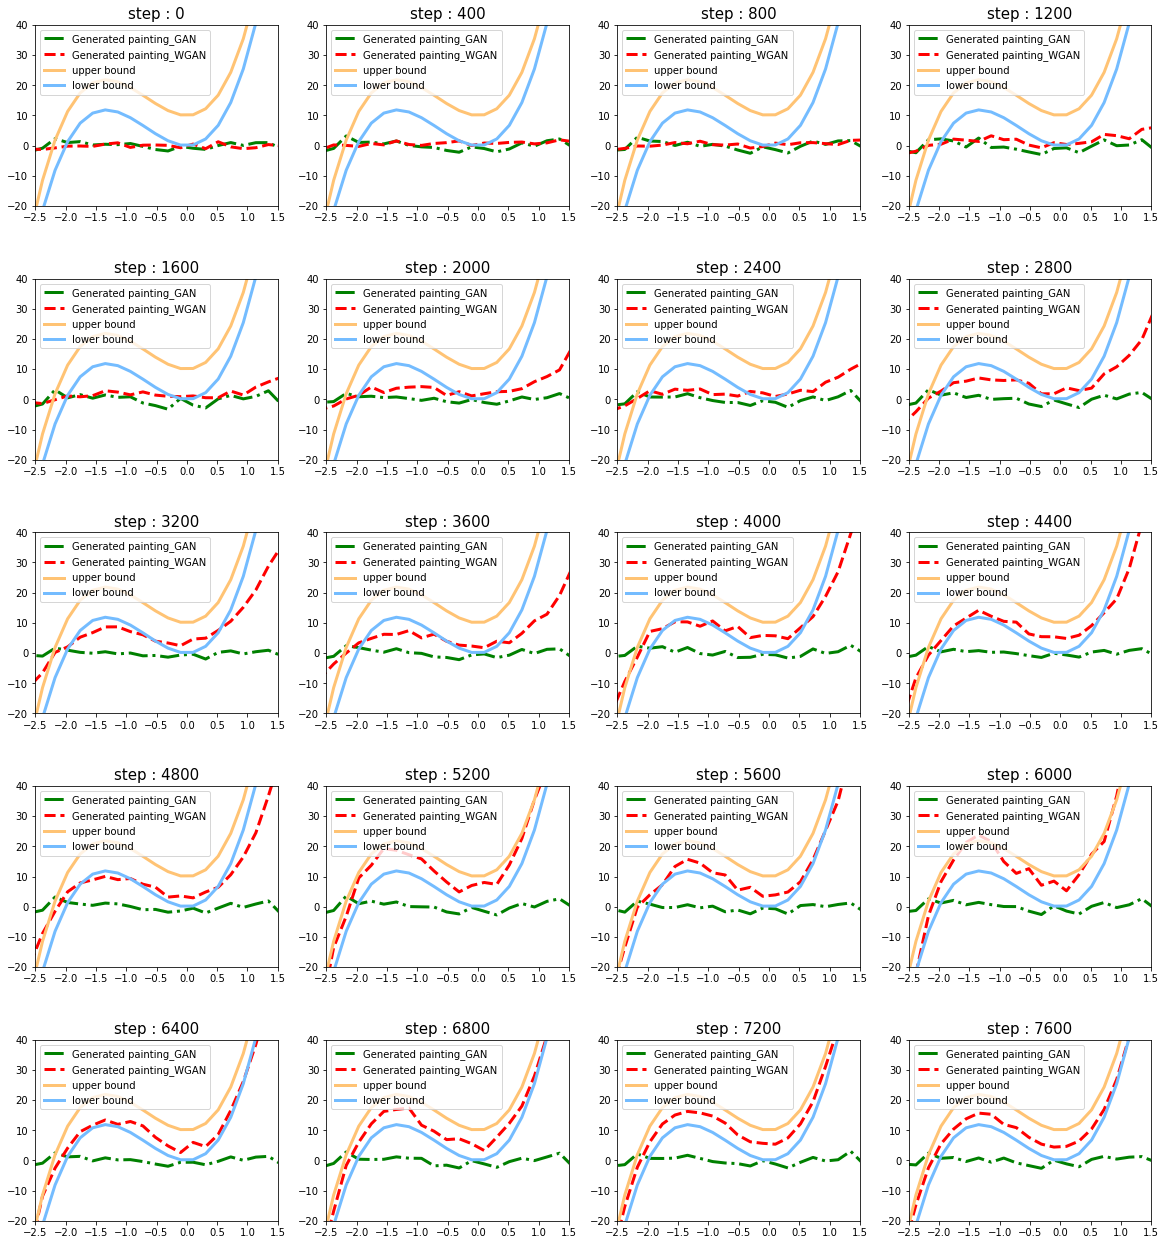

In [8]:
fig , ax = plt.subplots(5 , 4 , figsize = (20 , 22))
plt.subplots_adjust(wspace = 0.2 , hspace = 0.4)

for i in range(0 , 5):
    for j in range(0 , 4):
        G_paintings_GAN = G_paintings_list_GAN[4 * i + j]
        G_paintings_WGAN = G_paintings_list_WGAN[4 * i + j]
        ax[i , j].plot(PAINT_POINTS[0 , :] , G_paintings_GAN , c = 'g' , lw = 3 , ls = '-.' , label = 'Generated painting_GAN')
        ax[i , j].plot(PAINT_POINTS[0 , :] , G_paintings_WGAN , c = 'r' , lw = 3 , ls = '--' , label = 'Generated painting_WGAN')
        
        ax[i , j].plot(PAINT_POINTS[0 , :] , 
                       10 * np.power(PAINT_POINTS[0 , :] , 3) + 20 * np.power(PAINT_POINTS[0 , :] , 2) + 10 , 
                       c = '#ffc374' , lw = 3 , 
                       label = 'upper bound')
        
        ax[i , j].plot(PAINT_POINTS[0 , :] , 
                       10 * np.power(PAINT_POINTS[0 , :] , 3) + 20 * np.power(PAINT_POINTS[0 , :] , 2) + 0 , 
                       c = '#74BCFF' , lw = 3 , 
                       label = 'lower bound')
        
        ax[i , j].set_title('step : {:1d}'.format((4 * i + j) * 400) , fontsize = 15) 
        ax[i , j].set_xlim((-2.5 , 1.5)) 
        ax[i , j].set_ylim((-20 , 40))
        ax[i , j].legend(loc = 'upper left' , fontsize = 10)

### 從以上的結果可以發現，普通的GAN無法生成較為複雜的曲線，但WGAN卻可以做到